## Expected Free Energy minimization for mobile robot navigation

Wouter Kouw, last update: 30-12-2022

### Dynamics

Consider a mobile robot that moves according to:

$$\underbrace{\begin{bmatrix} c_{x,k} \\ c_{y,k} \\ \dot{c}_{x,k} \\ \dot{c}_{y,k} \end{bmatrix}}_{z_k} = \underbrace{\begin{bmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}}_{A} \underbrace{\begin{bmatrix} c_{x,k-1} \\ c_{y,k-1} \\ \dot{c}_{x,k-1} \\ \dot{c}_{y,k-1} \end{bmatrix}}_{z_{k-1}} + \underbrace{\begin{bmatrix} 0 & 0 \\ 0 & 0 \\ \Delta t & 0 \\ 0 & \Delta t \end{bmatrix}}_{B} \underbrace{\begin{bmatrix} u_{x,k} \\ u_{y,k}\end{bmatrix}}_{u_k} + q_k \, .$$

Process noise is white, $q_k \sim \mathcal{N}(0, Q)$, with 

$$Q = \begin{bmatrix} \frac{\Delta t^3}{3} \rho_x & 0 & \frac{\Delta t^2}{2} \rho_x & 0 \\
                      0 & \frac{\Delta t^3}{3} \rho_y & 0 & \frac{\Delta t^2}{2} \rho_y \\
                      \frac{\Delta t^2}{2} \rho_x & 0 & \Delta t \rho_x & 0 \\
                      0 & \frac{\Delta t^2}{2} \rho_y & 0 & \Delta t \rho_y \end{bmatrix} \, .$$

### Observations: triangulation

The robot positions itself in space using triangulation with respect to two beacons, $\beta_1$ and $\beta_2$. The positions of the beacons are known and they report the angle of the robot as follows:


The measurements are $y = [\alpha_1 \ \alpha_2]^{\top}$. As such, we have a likelihood function of the form:

$$\begin{align}
\alpha_1 &= \arccos\big(\frac{d_1^2 + L^2 - d_2^2}{2d_1 L} \big) \\
\alpha_2 &= \arccos\big(\frac{d_2^2 + L^2 - d_1^2}{2d_2 L} \big)
\end{align}$$

where $L$ is the distance between the beacons, $L = \|\beta_1 - \beta_2\|_2$, and $d_1$,$d_2$ are the distances to each of the beacons: $d_1 = \| x_k - \beta_1\|_2$ and $d_2 = \| x_k - \beta_2\|_2$. We denote this as:

$$y_k = g(x_k) + r_k$$

where $r_k$ is measurement noise caused by angle measurements and communication between the beacons and the robot.

### Probabilistic model

The above system can be captured with a probabibilistic state-space model of the form:

$$\begin{align}
p(z_0) &= \mathcal{N}(z_0 \mid m_0, S_0) \\
p(z_k \mid z_{k-1}, u_k) &= \mathcal{N}(z_k \mid Az_{k-1} + Bu_k, Q) \\
p(y_k \mid z_k) &= \mathcal{N}(y_k \mid g(z_k), R) \, .
\end{align}$$

We can simulate the behaviour of this system as follows:

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/syndr/Wouter/Onderzoek/Projecten/tue/efe-planning/FRAI2023-nlamb`


In [2]:
using Colors
using Optim
using ForwardDiff
using ProgressMeter
using LinearAlgebra
using ControlSystems
using Distributions
using Plots
default(label="", grid=false, linewidth=3, markersize=3, margin=15Plots.pt)

In [3]:
include("util.jl");

In [4]:
# Time

Δt = 0.02
len_time = 50
time = range(0, step=Δt, length=len_time)

0.0:0.02:0.98

In [5]:
# Dynamics

# Matrices
A = [1. 0. Δt 0.;
     0. 1. 0. Δt;
     0. 0. 1. 0.;
     0. 0. 0. 1.]
B = [0. 0.;
     0. 0.;
     Δt 0.;
     0. Δt]

# Process noise
σx = 1e-4
σy = 1e-4
Q = [Δt^3/3*σx         0.  Δt^2/2*σx        0.;
        0.     Δt^3/3*σy          0. Δt^2/2*σy;
    Δt^2/2*σx         0.       Δt*σx        0.;
        0.     Δt^2/2*σy          0.    Δt*σy;]

4×4 Matrix{Float64}:
 2.66667e-10  0.0          2.0e-8  0.0
 0.0          2.66667e-10  0.0     2.0e-8
 2.0e-8       0.0          2.0e-6  0.0
 0.0          2.0e-8       0.0     2.0e-6

In [6]:
# Observations

# Beacon coordinates
β1 = [-1., 0.]
β2 = [ 1., 0.];

# Nonlinear observation
function g(x)
    
    L  = norm(β1-β2,2)
    d1 = norm(x[1:2]-β1,2)
    d2 = norm(x[1:2]-β2,2)
    
    cosα1 = (d1^2 + L^2 - d2^2)./(2*d1*L)
    cosα2 = (d2^2 + L^2 - d1^2)./(2*d2*L)
    
    return [acos(cosα1), acos(cosα2)]
end

# Measurement noise
R = 1e-6*diagm(ones(2));

In [7]:
function update(z_kmin1, u_k)
   "Update environment" 
    
    # State transition
    z_k = rand(MvNormal(A*z_kmin1 + B*u_k, Q))
    
    # Emit noisy observation
    y_k = rand(MvNormal(g(z_k), R))
    
    return y_k, z_k
end;

In [8]:
# Setpoint (desired observation)
z_star = [0., 1.0, 0.0, 0.0]
y_star = g(z_star)

2-element Vector{Float64}:
 0.7853981633974485
 0.7853981633974485

In [9]:
# Initial state
z_0 = [0.0, -1.0, 0.0, 0.0]

# Preallocate
z = zeros(4,len_time)
y = zeros(2,len_time)

# Test control
u = rand(2,len_time)

# Start recursion
z_kmin1 = z_0
for k in 1:len_time
    
    # Update system
    y[:,k], z[:,k] = update(z_kmin1, u[:,k])
    
    # Update recursion
    z_kmin1 = z[:,k]
    
end

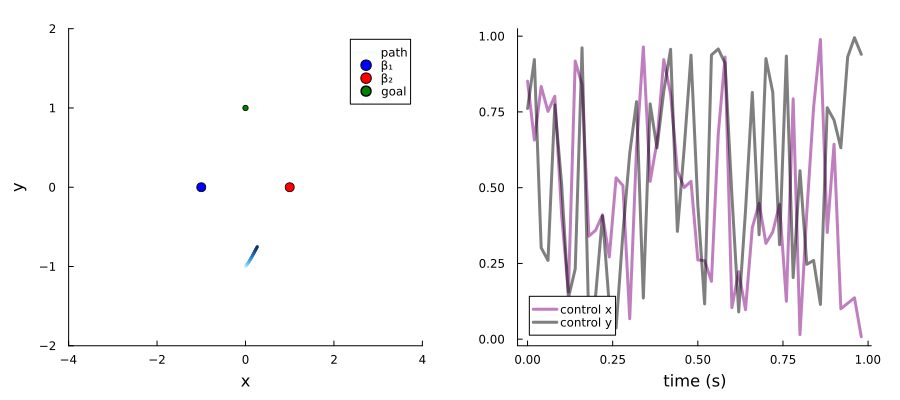

In [10]:
p1 = plot(z[1,:], z[2,:], c=colormap("Blues")[1:2:100], xlabel="x",ylabel="y", xlims=(-4, 4), ylims=(-2, 2), label="path")
scatter!([β1[1]], [β1[2]], color="blue", label="β₁", markersize=5)
scatter!([β2[1]], [β2[2]], color="red", label="β₂", markersize=5)
scatter!([z_star[1]], [z_star[2]], color="green", label="goal", markersize=3)
p2 = plot(time, u[1,:], color="purple", xlabel="time (s)", alpha=0.5, label="control x")
plot!(time, u[2,:], color="black", xlabel="time (s)", alpha=0.5, label="control y")

plot(p1, p2, layout=(1,2), size=(900,400))

## Expected Free Energy

From the agent's viewpoint, the evolution of these future variables are constrained by its generative model, rolled out into the future:
$$\begin{aligned}
p(y,z,u) &= \underbrace{q(z_{k})}_{\substack{\text{current}\\ \text{state}}} \cdot \underbrace{\prod_{t=k+1}^{k+T} p(y_t|z_t) \cdot p(z_t | z_{t-1}, u_t) p(u_t)}_{\text{generative model roll-out to future}} \, ,
\end{aligned}$$

where $y = (y_t, \dots, y_T)$, $z = (z_{t-1}, \dots, z_T)$ and $u = (u_t, \dots, u_T)$. 

Consider the varational free energy functional for estimating posterior beliefs $q(z,u)$ over future states and control signals, with an expectation over future observations $q(y \mid z)$: 

$$\begin{aligned}
H[q] &= \overbrace{\iint q(y \mid z)}^{\text{marginalize }y} \bigg( \overbrace{\int q(z,u) \log \frac{q(z,u)}{p(y,z,u)} }^{\text{variational free energy}}\bigg) \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(y,z,u) \log \frac{q(z,u)}{p(y,z,u)} \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(y,z|u) q(u) \log \frac{q(z|u) q(u)}{p(y,z|u) p(u)} \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(u) \bigg(\sum_{y,z} q(y,z|u) \log \frac{q(s|u) q(u)}{p(y,z|u) p(u)}\bigg) \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(u) \bigg( \log q(u) + \log \frac{1}{p(u)}+ \underbrace{q(y,z|u) \log \frac{q(z|u)}{p(y,z|u)}}_{G(u)}\bigg) \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(u) \log \frac{q(u)}{p(u)\exp\left(- G(u)\right) } \mathrm{d}u  \, .
\end{aligned}$$

We can recognize a KL-divergence between $q(u)$ and the function $p(u)\exp\left(- G(u)\right)$, which will be minimal when $q(u) = p(u)\exp\left(- G(u)\right)$. The $G$ function is known as the _Expected Free Energy_. Let's look at it in detail for a future observation $t$,

$$ G(u_t) = \iint q(y_t, z_t \mid u_t) \log \frac{q(z_t \mid u_t)}{p(y_t, z_t \mid u_t)} \mathrm{d}y_t \, \mathrm{d}z_t \, ,$$

where 

$$\begin{aligned}
% q(y_t \mid z_t) &= \mathcal{N}(y_t \mid Cz_t, R) \\
% q(z_t \mid u_t) &= \int p(z_t \mid z_{t-1}, u_t) q(z_{t-1}) \mathrm{d}z_{t-1} \\
% &= \mathcal{N}(z_t \mid A m_{t-1} + Bu_t, AS_{t-1}A^{\top} + Q) \\
p(y_t, z_t \mid u_t) &= \int p(y_t \mid z_t) p(z_t \mid z_{t-1}, u_t) q(z_{t-1}) \mathrm{d}z_{t-1} \\
&= \mathcal{N}(\begin{bmatrix} y_t \\ z_t \end{bmatrix} \mid \begin{bmatrix} C(A m_{t-1} + Bu_t) \\ A m_{t-1} + Bu_t \end{bmatrix}, \begin{bmatrix} C(AS_{t-1}A^{\top} + Q) C^{\top} + R & C(AS_{t-1}A^{\top} + Q) \\ (AS_{t-1}A^{\top} + Q)C^{\top} & AS_{t-1}A^{\top} + Q \end{bmatrix}) \, ,
\end{aligned}$$

with the approximate posterior for the previous state $q(z_{t-1}) = \mathcal{N}(z_{t-1} \mid m_{t-1}, S_{t-1})$. The distribution $q(z_t \mid u_t)$ is constructed from the state transition:

$$q(z_t \mid u_t) = \int p(z_t \mid z_{t-1}, u_t) q(z_{t-1}) \mathrm{d}z_{t-1} = \mathcal{N}(z_t \mid A m_{t-1} + Bu_t, AS_{t-1}A^{\top} + Q) \, ,$$

and $q(y_t, z_t \mid u) = p(y_t \mid z_t) q(z_t \mid u_t)$ which is equivalent to $p(y_t, z_t \mid u_t)$ in this case. Note that - during planning and in linear Gaussian models - we can drive the KL-divergence between the approximate posteriors $q$ and the true posteriors $p$ to 0, thus allowing us to swap $q$ for $p$.

We will decompose this EFE function into ambiguity plus risk terms (see [lecture slides](https://nbviewer.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Intelligent-Agents-and-Active-Inference.ipynb) for more detail). To do so, we will decompose $p(y_t,z_t \mid u_t)$ into $p^\prime(y_t)p(z_t|y_t,u_t)$ where $p\prime(y_t)$ is a distribution over the goal state, a.k.a. a _goal prior_; $p^\prime(y) = \mathcal{N}(y \mid m_*, s_*)$. The derivation goes as follows:

$$\begin{aligned}
G(u_t) &= \int  q(y_t,z_t|u_t) \log \frac{q(z_t|u_t)}{p^\prime(y_t)p(z_t|y_t,u_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t, z_t \mid u_t) \log \frac{q(z_t \mid u_t)}{p^\prime(y_t)} \frac{1}{p(z_t \mid y_t, u_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t, z_t \mid u_t) \log \frac{q(z_t \mid u_t)}{p^\prime(y_t)} \frac{p(y_t \mid u_t)}{p(y_t \mid z_t)p(z_t \mid u_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t,z_t|u_t) \log \frac{q(z_t|u_t)}{p(y_t|z_t)p(z_t|u_t)} \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t,z_t|u_t) \log \frac{q(z_t|u_t)}{p(y_t|z_t)p(z_t|u_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t + \int q(y_t,z_t|u_t) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  p(z_t|u_t) p(y_t|z_t) \log \frac{1}{p(y_t|z_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t + \int p(z|u) p(y|z) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t \\
&= \underbrace{\int  p(z_t|u_t) \int p(y_t|z_t) \log \frac{1}{p(y_t|z_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t}_{\text{ambiguity}} + \underbrace{\int p(y_t|u_t) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t}_{\text{risk}} \ \, ,
\end{aligned}$$

Ambiguity is an expectation over an entropy, which - in the case of a Gaussian likelihood - is actually independent of the state,

$$\int p(y_t|z_t) \log p(y_t|z_t) \mathrm{d}y_t = \frac{1}{2}\big(\log 2\pi R - 1\big) \, ,$$

so the expectation over $p(z_t|u_t)$ doesn't even apply. As you may have noticed, the control $u_t$ doesn't affect ambiguity which means there is no information-seeking behaviour in linear Gaussian state-space models.

The risk term is a KL-divergence between the Gaussian,

$$\begin{aligned}
    p(y_t|u_t) &= \int p(y_t, z_t \mid u_t) \, \mathrm{d}z_t  \\
    &= \int \mathcal{N}(\begin{bmatrix} y_t \\ z_t \end{bmatrix} \mid \begin{bmatrix} C(A m_{t-1} + Bu_t) \\ A m_{t-1} + Bu_t \end{bmatrix}, \begin{bmatrix} C(AS_{t-1}A^{\top} + Q) C^{\top} + R & C(AS_{t-1}A^{\top} + Q) \\ (AS_{t-1}A^{\top} + Q)C^{\top} & AS_{t-1}A^{\top} + Q \end{bmatrix}) \, \mathrm{d}z_t \\
    &= \mathcal{N}(y_t \mid C(A m_{t-1} + Bu_t) , C(AS_{t-1}A^{\top} + Q) C^{\top} + R) \, ,
    \end{aligned}$$
    
and the goal prior $p^\prime(y_t)$. The formula for the KL-divergence between two Gaussians is (see [wiki](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions)):

$$\begin{aligned}
D_{\text{KL}}( \mathcal{N}(x \mid m_1, \sigma_1) || \mathcal{N}(x \mid m_2, \sigma_2) ) = \frac{1}{2} \Big[\log\frac{|\Sigma_2|}{|\Sigma_1|} - d + \text{tr}(\Sigma_2^{-1}\Sigma_1) + (\mu_2 - \mu_1)^{\top}\Sigma_2^{-1}(\mu_2 - \mu_1) \Big] \, .
\end{aligned}$$

For our distribution, this becomes:

$$\int p(y_t|u_t) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t = \frac{1}{2} \Big[\log\frac{s_*}{|C(AS_{t-1}A^{\top} + Q) C^{\top} + R|} - 1 + \text{tr}(\frac{(C(AS_{t-1}A^{\top} + Q) C^{\top} + R)}{s_*}) + \frac{\big(m_* - (C(A m_{t-1} + Bu_t))\big)^2}{s_*}) \Big]$$


The decomposition is the same for any future state $t$. We may thus unroll the policy as $G(u) = \sum_{t=k+1}^{TT} G(u_t)$.

---

The above equations can be written down to form an objective function.

In [11]:
function ambiguity(Σ,Γ,S)
   return 0.5*logdet(Σ - Γ'*inv(S)*Γ)
end

ambiguity (generic function with 1 method)

In [31]:
function risk(μ, Σ, goal)
    "Naive version"
    m_star, S_star = goal
    iS = inv(S_star)
    return log(det(S_star)/det(Σ)) + (μ-m_star)'*iS*(μ-m_star) + tr(iS*Σ)
#     return (μ-m_star)'*iS*(μ-m_star)
end

# function risk(μ, Σ, goal)
#     "Numerically improved version"
    
#     m_star, S_star = goal
#     k = length(m_star)
    
#     L0 = cholesky(Σ).L
#     L1 = cholesky(S_star).L
    
#     M = inv(L1)*L0
#     y = inv(L1)*(m_star - μ)
    
#     return 0.5(sum(M[:].^2) - k + norm(y,1).^2 + 2*sum([log(L1[i,i]./L0[i,i]) for i in 1:k]))
# end

risk (generic function with 1 method)

In [32]:
function EFE(u::AbstractVector, 
             state::Tuple{Vector{Float64}, Matrix{Float64}}, 
             goal::Tuple{Float64,Float64}; 
             s_u::Float64=1.0,
             time_horizon::Int64=1)
    "Expected Free Energy"
    
    # Unpack parameters of current state
    m_tmin1, S_tmin1 = state
    
    # Start cumulative sum
    cEFE = 0.0
    for t in 1:time_horizon
        
        # State transition p(z_t | u_t)
        m_t = A*m_tmin1 + B*u[(t-1)*2+1:2t]
        S_t = A*S_tmin1*A' + Q

        # Unscented transform moments
        μ, Σ, Γ = ET2(m_t, S_t, g, addmatrix=R, forceHermitian=true)
        
        # Cumulate EFE
        cEFE += ambiguity(Σ,Γ,S) + risk(μ,Σ,goal)# + 1/(s_u)*u[t]^2
        
        # Update state recursion
        m_tmin1 = m_t
        S_tmin1 = S_t
                
    end
    return cEFE
end

EFE (generic function with 1 method)

### Visualization

In [86]:
num_grid = 101
xgrid = range(-2, 2, length=num_grid)
ygrid = range(-10, 1, length=num_grid)
S_grid = diagm(1e0*ones(4))
S_star = diagm(1e0*ones(2))

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

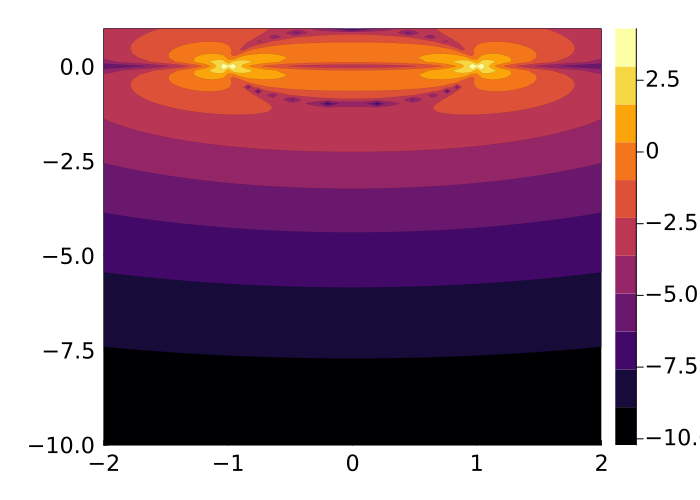

In [87]:
# Plot ambiguity over state-space

function helper1(x,y; S=S_grid)
    μ, Σ, Γ = ET2([x,y,0.,0.], S, g, addmatrix=R, forceHermitian=true)
    return ambiguity(Σ,Γ, S)
end

contourf(xgrid, ygrid, helper1, levels=10, linewidth=0, tickfontsize=15, size=(700,500))
# surface(xgrid, ygrid, helper1)

In [88]:
savefig("figures/triangulation-ambiguity-statespace.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-planning/FRAI2023-nlamb/figures/triangulation-ambiguity-statespace.png"

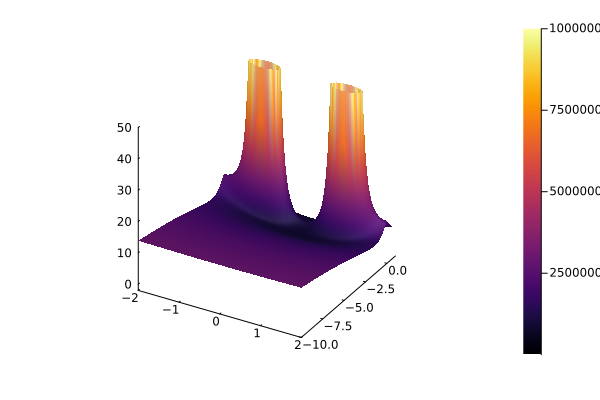

In [89]:
# Plot risk over state-space

function helper2(x,y; goal=(g(z_star), S_star), S=S_grid)
    
    m_star, S_star = goal
    μ, Σ, Γ = ET2([x,y,0.,0.], S, g, addmatrix=R, forceHermitian=true)
    
    return risk(μ,Σ, goal)
end

# contourf(xgrid, ygrid, helper2, levels=10, linewidth=0, size=(700,500))
# scatter!([z_star[1]], [z_star[2]], color="black", markersize=10, tickfontsize=15)
surface(xgrid, ygrid, helper2, zlims=(-2,50.))

In [90]:
savefig("figures/triangulation-risk-statespace.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-planning/FRAI2023-nlamb/figures/triangulation-risk-statespace.png"

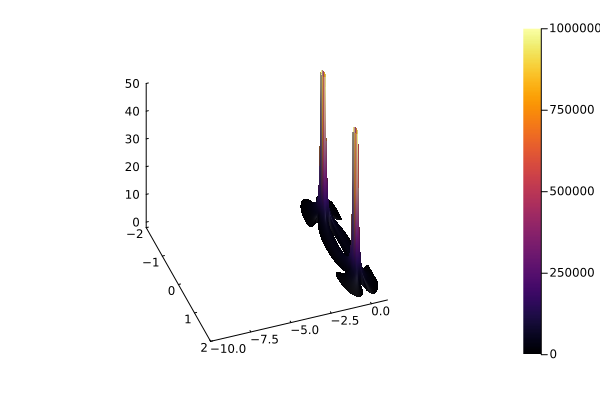

In [91]:
# Plot both ambiguity and risk over state-space

function helper3(x,y; goal=(g(z_star), S_star), S=S_grid)
    
    m_star, S_star = goal
    μ, Σ, Γ = ET2([x,y,0.,0.], S, g, addmatrix=R, forceHermitian=true)
    
    return ambiguity(Σ,Γ,S) + risk(μ,Σ, goal)./100
end

# contourf(xgrid, ygrid, helper3, levels=10, linewidth=0, size=(700,500))
# scatter!([z_star[1]], [z_star[2]], color="green", markersize=10, tickfontsize=15)
surface(xgrid, ygrid, helper3, zlims=(-2,50.), camera=[70,40])

In [92]:
savefig("figures/triangulation-risk+ambiguity-statespace.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-planning/FRAI2023-nlamb/figures/triangulation-risk+ambiguity-statespace.png"